In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from utils import plot_clusters, elbow
from ydata_profiling import ProfileReport

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')


PATH_DATA = "../data/Mall_Customers.csv"
df = pd.read_csv(PATH_DATA)

In [ ]:
display(df.info())

with pd.option_context("display.float_format", "{:.2f}".format):
    display(df.describe())

display(df.describe(exclude="number"))

print(df.isnull().sum())

In [ ]:
profile = ProfileReport(df)
profile.to_file("../reports/eda_supermarket.html")

### Preprocessing, applying Normalization and OneHotEncoder

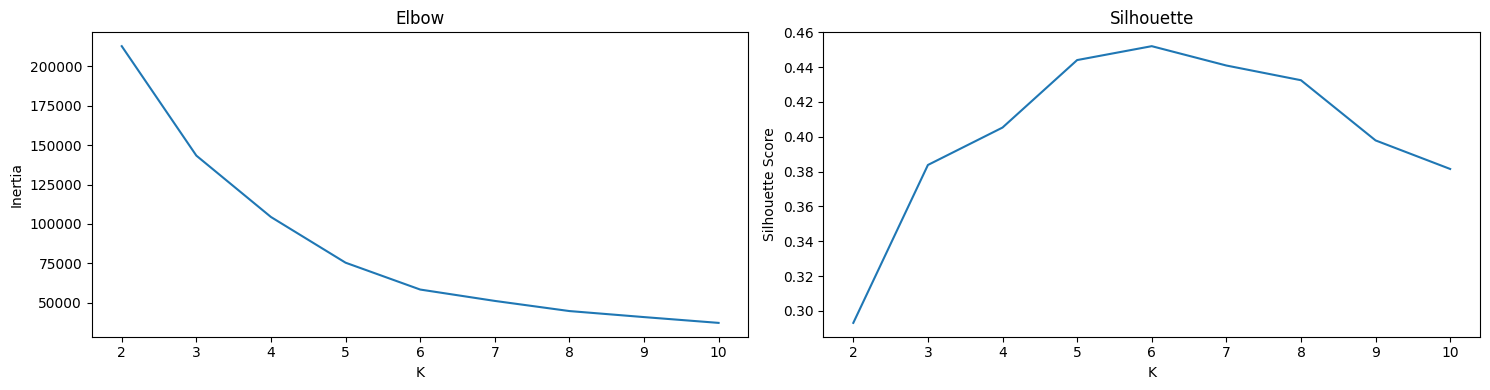

In [2]:
df = df.drop("CustomerID", axis=1)
df['gender_onehot'] = df["Gender"].apply(lambda x: 1 if x == "Male" else 0 )
df = df.drop("Gender", axis=1)

preprocessing = ColumnTransformer(
    [
        ("min_max", MinMaxScaler(), ["Age", "Annual Income (k$)", "Spending Score (1-100)"]),
    ]
)

df_scaled = pd.DataFrame(
    preprocessing.fit_transform(df),
    columns=preprocessing.get_feature_names_out()
)

elbow(df, random_state=42)

# Trainning Model

In [3]:
df_clustered = df.copy()

pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ('clustering', KMeans(n_clusters=4, random_state=12)),
    ]
)

pipeline.fit(df_clustered)

### I'm only getting the result of cluster that a row was classified 
### and the centroid to plot on the chart to show where the cluster was represented

In [ ]:
labels = pipeline["clustering"].labels_
centers = pipeline["clustering"].cluster_centers_
df_clustered["cluster"] = labels
df_scaled['cluster'] = labels

### I use df_scaled with the columns transformed to plot on 3d chart but its not considering the gender columns because 3d only accepts 3 variables

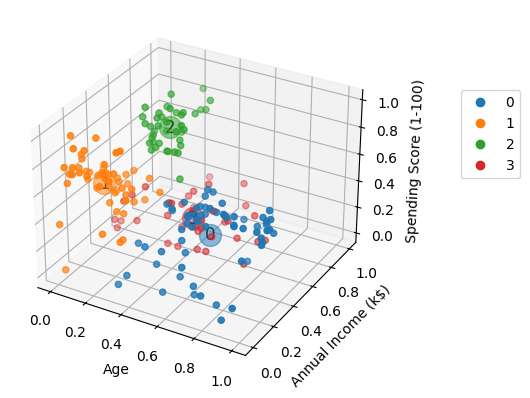

In [4]:
plot_clusters(
    df_scaled,
    ["min_max__Age", "min_max__Annual Income (k$)", "min_max__Spending Score (1-100)"],
    4,
    centers,
    "cluster"
)

### I use df_clustered without the columns got into transformer for better interpretting

In [21]:
df_clustered.drop(["gender_onehot"], axis=1, inplace=True)

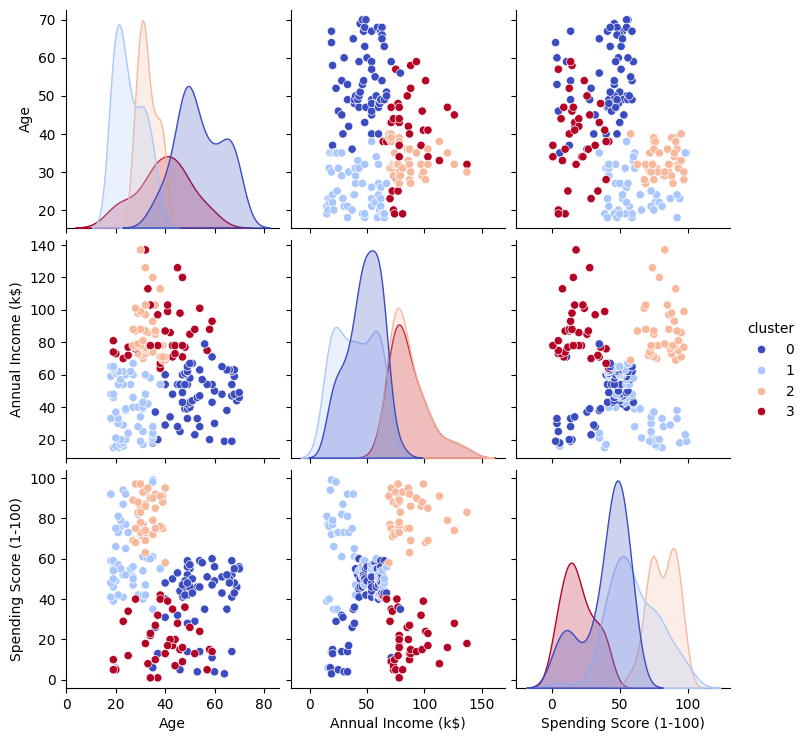

In [23]:
sns.pairplot(df_clustered, diag_kind='kde', hue='cluster', palette="coolwarm")
plt.show()

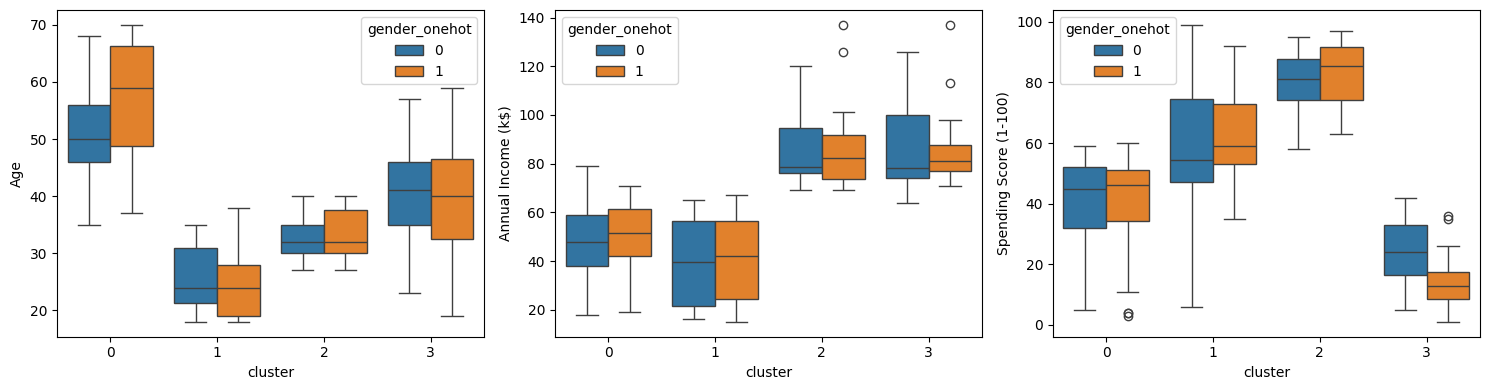

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), tight_layout=True)
for ax, col in zip(axs, df_clustered.select_dtypes("number")):
    sns.boxplot(data=df_clustered, x="cluster", hue= "gender_onehot", y=col, ax=ax)

plt.show()

### Reducing dimensions with PCA for considering gender column on 3d chart

In [8]:
from sklearn.decomposition import PCA


pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("pca", PCA(n_components=3, random_state=12)),
        ("clustering", KMeans(n_clusters=4, random_state=12))
    ]
)

pipeline.fit(df)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('min_max', MinMaxScaler(),
                                                  ['Age', 'Annual Income (k$)',
                                                   'Spending Score '
                                                   '(1-100)'])])),
                ('pca', PCA(n_components=3, random_state=12)),
                ('clustering', KMeans(n_clusters=4, random_state=12))])

In [14]:
df_pca = pd.DataFrame(
    pipeline[:2].fit_transform(df),
    columns=pipeline[:2].get_feature_names_out()
)

centers_pca = pipeline["clustering"].cluster_centers_
df_pca['cluster'] = pipeline["clustering"].labels_

plot_clusters(
    df_pca,
    list(df_pca.columns),
    4,
    centers_pca,
    "cluster"
)

,pca0,pca1,pca2
0,-0.192221,-0.319683,-0.398865
1,-0.458175,0.018152,-0.381857
2,0.052562,-0.551854,-0.401155
3,-0.402357,0.014239,-0.372833
4,-0.031648,-0.155578,-0.368647
